In [1]:
## Imports and Initialization -------------------------------------------------|
print("Importing dependencies... ")

import sys
import os, os.path
sys.path.append(os.path.abspath(".."))  # Adjust path to package root

# third party
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# internal
import abstraction
import algorithm
from astropy.io import fits
from utility import IndexSchema, get_fits_paths, load_image_data
from examples.fits_to_mp4 import fits_to_mp4, data_to_mp4
from reference_method import ExternalRefs, RollingWindow

## Fetch Data ------------------------------------------------------------------

files_dir = os.path.abspath(os.path.join(".", "media", "large"))
files = get_fits_paths(files_dir)
files = files[610:622]
# print("\n".join(files))
print(f"{len(files)} files found")


Importing dependencies... 
12 files found



# Perform Destretching:

In [2]:
# create variable paths for destretching files

kernel_sizes: np.ndarray[np.int64] = np.array([128, 64])
out_off_dir = os.path.join(files_dir, "off")
out_sum_dir = os.path.join(files_dir, "sum")
out_rolling_sum_dir = os.path.join(files_dir, "rolling_sum")
out_off_control_dir = os.path.join(files_dir, "off_control")
out_avg_dir = os.path.join(files_dir, "avg")
out_ref_dir = os.path.join(files_dir, "ref")
out_dir = os.path.join(files_dir, "destretched")
out_dir_control = os.path.join(files_dir, "destretched_control")
out_off_final_dir = os.path.join(files_dir, "off_final")
print(out_off_dir)
print(out_avg_dir)
print(out_dir)

/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off
/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg
/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched


In [3]:
# calculate offset vectors
print(f"calculating offsets... {out_off_dir}")
abstraction.calc_offset_vectors(
	files,
	out_off_dir,
	"off",
	kernel_sizes=kernel_sizes,
	# ref_method=ExternalRefs(files, get_fits_paths(out_ref_dir))
)

calculating offsets... /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off
Searching for image data in specified files...
ref image checksum: 3994515712.0
processing image #0../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06100.seq021.ext221.fits
ref image checksum: 0.5732421875
ref image checksum: 0.5732421875
processing image #1../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06110.seq021.ext231.fits
ref image checksum: 0.5732421875
ref image checksum: 3990718976.0
processing image #2../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06120.seq021.ext241.fits
ref image checksum: -5.6123046875
ref image checksum: 3995153664.0
processing image #3../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.2

['/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off00.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off01.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off02.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off03.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off04.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off05.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off06.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off07.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/off08.off.fits',
 '/home/tteck/Documents/development/f

In [4]:
# calculate offset control vectors:
# these are offsets that we know are correct, and will result in a proper 
# destretch if applied to the image data
print(f"calculating offsets... {out_off_control_dir}")
abstraction.calc_offset_vectors(
	files,
	out_off_control_dir,
	"off_cont",
	kernel_sizes=kernel_sizes,
	ref_method=RollingWindow(files, left=5, right=5)
)

calculating offsets... /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control
Searching for image data in specified files...
ref image checksum: 3997123584.0
processing image #0../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06100.seq021.ext221.fits
ref image checksum: 5.8076171875
ref image checksum: 3997123584.0
processing image #1../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06110.seq021.ext231.fits
ref image checksum: 5.8076171875
ref image checksum: 3997123584.0
processing image #2../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06120.seq021.ext241.fits
ref image checksum: 5.8076171875
ref image checksum: 3997123584.0
processing image #3../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whiteligh

['/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont00.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont01.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont02.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont03.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont04.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont05.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont06.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont07.off.fits',
 '/home/tteck/Documents/development/flct

In [3]:
# calculate the cumulative sum offsets
abstraction.calc_cumulative_sums(
    get_fits_paths(out_off_dir),
    out_sum_dir
)

# calculate the rolling sums of the cumulative sum offsets
abstraction.calc_rolling_sum(
    get_fits_paths(out_sum_dir),
    out_rolling_sum_dir
)

# calculate the difs
abstraction.calc_difs(
    get_fits_paths(out_sum_dir),
    get_fits_paths(out_rolling_sum_dir),
    out_off_final_dir,
    "final"
)

In [11]:
# apply the final offset vectors to destretch the image data
result = abstraction.destretch_files(
	files,
	get_fits_paths(out_off_final_dir),
	out_dir,
	"destr",
	#in_avg_files=get_fits_paths(out_avg_dir),
)

# apply the control offset vectors to destretch the image data, this should 
# result in the destretched imagees that we know are correct
abstraction.destretch_files(
	files,
	get_fits_paths(out_off_control_dir),
	out_dir_control,
	"destr_control"
)

Searching for image data in specified files...
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr00.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr01.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr02.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr03.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr04.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr05.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr06.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretche

['/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control00.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control01.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control02.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control03.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control04.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control05.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control06.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched

# Video Output

In [13]:
# output video files
out_file_orig_vid = os.path.join(files_dir, "video_original.mp4")
out_file_destr_vid = os.path.join(files_dir, "video_destretched.mp4")
out_file_destr_control_vid = os.path.join(files_dir, "video_destretched_control.mp4")
out_file_flow_vid = os.path.join(files_dir, "video_flowmap.mp4")
out_file_off_vid = os.path.join(files_dir, "video_offmap.mp4")
out_file_off_final_vid = os.path.join(files_dir, "video_offmap_final.mp4")
out_file_off_control_vid = os.path.join(files_dir, "video_offmap_control.mp4")

# output results as video files
fits_to_mp4(get_fits_paths(out_dir), out_file_destr_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25)
fits_to_mp4(get_fits_paths(out_dir_control), out_file_destr_control_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25)
fits_to_mp4(files, out_file_orig_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25)
fits_to_mp4(get_fits_paths(out_off_dir), out_file_off_vid, 60, "copper", IndexSchema.TYX, 0.2, 1.25, True)
fits_to_mp4(get_fits_paths(out_off_final_dir), out_file_off_final_vid, 60, "copper", IndexSchema.TYX, 0.2, 1.25, True)
fits_to_mp4(get_fits_paths(out_off_control_dir), out_file_off_control_vid, 60, "copper", IndexSchema.TYX, 0.2, 1.25, True)
fits_to_mp4(get_fits_paths(out_rolling_sum_dir), out_file_flow_vid, 60, "copper", IndexSchema.TXY, 0.2, 1.25, True)

print("Demo Complete!")

Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_destretched.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_destretched_control.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_original.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_offmap.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_offmap_final.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_offmap_control.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_flowmap.mp4, with 12 frames
Demo Complete!


In [7]:
def get_plot_data(index: int, axis: int):
	
	# load offset data and configure so it can be used in versatile ways through plotting
	out_off_final_files = get_fits_paths(out_off_final_dir)
	out_off_control_files = get_fits_paths(out_off_control_dir)
	off_final_data = load_image_data(out_off_final_files[index], z_index=None)
	off_control_data = load_image_data(out_off_control_files[index], z_index=None)
	off_final_data_rgb = np.zeros((off_final_data.shape[1], off_final_data.shape[2], 3))
	off_control_data_rgb = np.zeros((off_control_data.shape[1], off_control_data.shape[2], 3))
	off_final_data_rgb[:,:,0] = off_final_data[0]
	off_final_data_rgb[:,:,1] = off_final_data[1]
	off_control_data_rgb[:,:,0] = off_control_data[0]
	off_control_data_rgb[:,:,1] = off_control_data[1]

	# calculate vmin and max so both images can be displayed at the same intensity scale
	vmin, vmax = (
		min(off_final_data.min(), off_control_data.min()), 
		max(off_final_data.max(), off_control_data.max())
	)
	end = axis+1
	dif = abs(off_final_data_rgb - off_control_data_rgb) / 2

	# setup plot data to visualize both x and y axes at once
	if axis < 0:
		axis = 0
		end = 3
		off_final_data_rgb = (
			(off_final_data_rgb + off_final_data_rgb.min()) / 
			(off_final_data_rgb.min() - off_final_data_rgb.max())
		)
		off_control_data_rgb = (
			(off_control_data_rgb + off_control_data_rgb.min()) / 
			(off_control_data_rgb.min() - off_control_data_rgb.max())
		)
		off_final_data_rgb[:,:,2] = 0
		off_control_data_rgb[:,:,2] = 0

	return off_final_data_rgb, off_control_data_rgb, dif, axis, end, vmin, vmax

abs dif sum 0: 1.400873283739076


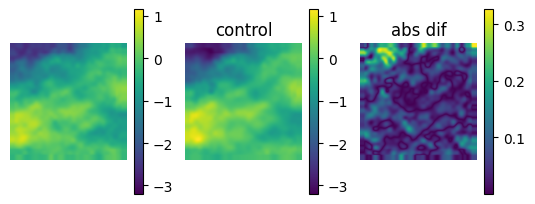

abs dif sum 1: 1.5982782757357945


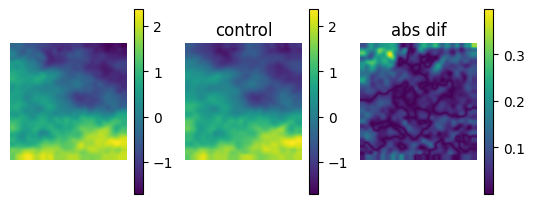

abs dif sum 2: 1.577426857688005


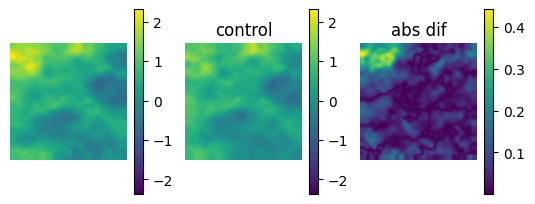

abs dif sum 3: 1.3854928391579715


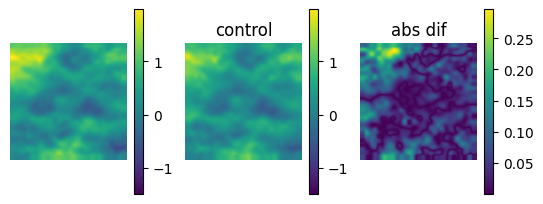

abs dif sum 4: 1.5099006868840077


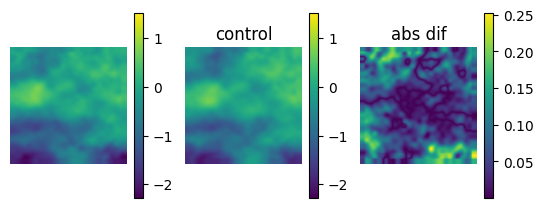

abs dif sum 5: 0.9869137801041047


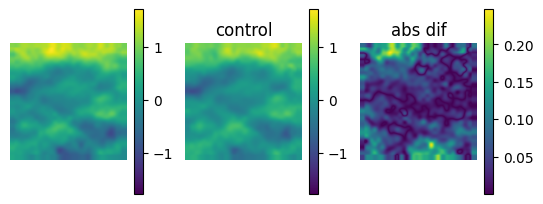

abs dif sum 6: 0.773086537206813


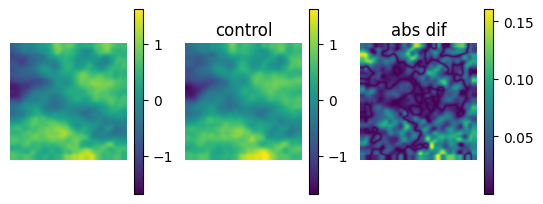

abs dif sum 7: 0.8561370656465463


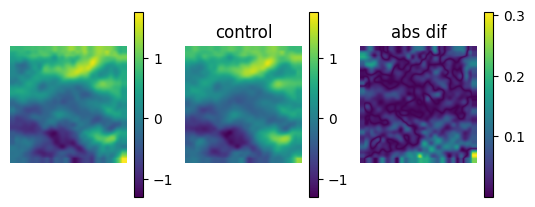

abs dif sum 8: 0.9654181807625724


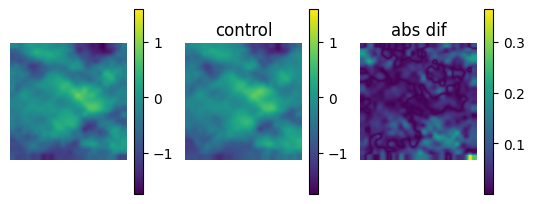

abs dif sum 9: 0.9878382162562576


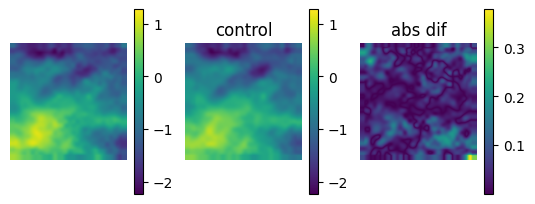

abs dif sum 10: 1.0252150632103048


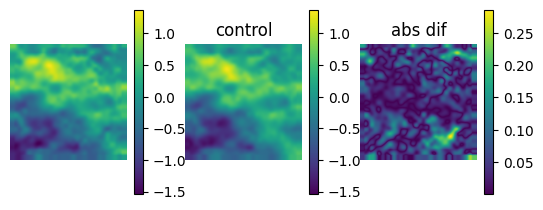

abs dif sum 11: 7.954663716229483


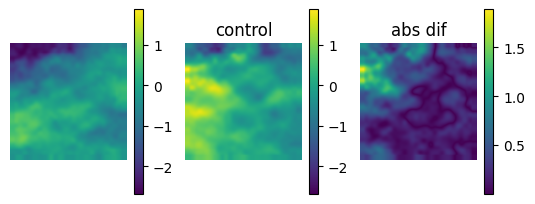

In [10]:
count = len(get_fits_paths(out_off_final_dir))
for i in range(count):
	
	# change axis to visualize x axis (0) or y axis (1), 
	# -1 visualizes them both as a normal map
	axis = 0

	off_final_data_rgb, off_control_data_rgb, dif, axis, end, vmin, vmax = get_plot_data(i, axis)

	plt.subplot(1, 3, 1)
	plt.imshow(off_final_data_rgb[:,:,axis:end], vmin=vmin, vmax=vmax)
	plt.colorbar(shrink=0.5)
	plt.axis("off")
	
	plt.subplot(1, 3, 2)
	plt.imshow(off_control_data_rgb[:,:,axis:end], vmin=vmin, vmax=vmax)
	plt.colorbar(shrink=0.5)
	plt.title("control")
	plt.axis("off")
	
	plt.subplot(1, 3, 3)
	plt.imshow(dif[:,:,axis:end])
	plt.colorbar(shrink=0.5)
	plt.title("abs dif")
	plt.axis("off")

	print(f"abs dif sum {i}: {dif.sum()/100000.0}")

	plt.show()